# 医疗保险欺诈识别模型

## 导入库和原始数据

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

origin_data = pd.read_csv('data.csv')
features = origin_data.columns.drop(['RES'])

target = 'RES'

In [92]:
# 下载字体
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"

import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')

--2024-04-15 11:52:48--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3037::6815:17f, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  24.2MB/s    in 0.4s    

2024-04-15 11:52:49 (24.2 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



## 原始数据分析

### 查看原始数据

In [22]:
origin_data.describe()

个人编码  一天去两家医院的天数  就诊的月数  月就诊天数_MAX  月就诊天数_AVG  月就诊医院数_MAX  \
count           16000       16000  16000      16000      16000       16000   
mean  352000000000000           2      6          8          6           2   
std                 0           5      1          4          3           1   
min   352000000000000           0      1          1          1           1   
25%   352000000000000           0      6          5          4           1   
50%   352000000000000           0      6          7          5           2   
75%   352000000000000           0      6         10          7           3   
max   352000000000000         108      7         31         30           8   

       月就诊医院数_AVG  就诊次数_SUM  月就诊次数_MAX  月就诊次数_AVG  月统筹金额_MAX  月统筹金额_AVG  \
count       16000     16000      16000      16000      16000      16000   
mean            2        37          8          6       3943       2783   
std             1        24          5          4       2936       1858   
min             1         1          1          1          0          0   
25%             1        22          5          4       2420       1793   
50%             2        32          7          5       3125       2255   
75%             2        46         10          8       4464       3136   
max             7       307         75         51      44590      37403   

       月药品金额_MAX  月药品金额_AVG  医院_就诊天数_MAX  医院_就诊天数_AVG  医院_统筹金_MAX  医院_统筹金_AVG  \
count      16000      16000        16000        16000       16000       16000   
mean        3631       2603           27           19       12603        9056   
std         2683       1776           18           14        9508        8319   
min            0          0            1            1           0           0   
25%         2352       1752           14           11        7625        4731   
50%         3002       2184           23           15       10280        6563   
75%         4120       2948           33           23       13993       10622   
max        77842      38656          180          172      100727      100727   

       医院_药品_MAX  医院_药品_AVG  医院编码_NN  顺序号_NN  交易时间DD_NN  交易时间YYYY_NN  \
count      16000      16000    16000   16000      16000        16000   
mean       11697       8258        2      91         34            1   
std         8556       6949        1      65         20            0   
min            0          0        1       1          1            1   
25%         7449       4584        1      54         21            1   
50%        10104       6365        2      78         30            1   
75%        13466      10197        3     110         43            1   
max       203168     151598        9    1415        180            1   

       交易时间YYYYMM_NN  住院天数_SUM  个人账户金额_SUM  统筹支付金额_SUM  ALL_SUM  可用账户报销金额_SUM  \
count          16000     16000       16000       16000    16000         16000   
mean               6         0        2319       16248    18582          2200   
std                1         0        2428       10697    13507          2369   
min                1         0           1           0        4             0   
25%                6         0        1208       10556    11902          1143   
50%                6         0        1630       13303    14868          1531   
75%                6         0        2446       18474    20600          2295   
max                7         0       45519      125861   240320         45519   

       药品费发生金额_SUM  药品费自费金额_SUM  药品费申报金额_SUM  贵重药品发生金额_SUM  中成药费发生金额_SUM  \
count        16000        16000        16000         16000         16000   
mean         15276           81        15024          2710          3402   
std          10536          216        10241          6256          3819   
min              0            0            0             0             0   
25%          10313            0        10190             0          1441   
50%          12877            8        12740          1095          2703 

In [23]:
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 82 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   个人编码               16000 non-null  float64
 1   一天去两家医院的天数         16000 non-null  int64  
 2   就诊的月数              16000 non-null  int64  
 3   月就诊天数_MAX          16000 non-null  int64  
 4   月就诊天数_AVG          16000 non-null  float64
 5   月就诊医院数_MAX         16000 non-null  int64  
 6   月就诊医院数_AVG         16000 non-null  float64
 7   就诊次数_SUM           16000 non-null  int64  
 8   月就诊次数_MAX          16000 non-null  int64  
 9   月就诊次数_AVG          16000 non-null  float64
 10  月统筹金额_MAX          16000 non-null  float64
 11  月统筹金额_AVG          16000 non-null  float64
 12  月药品金额_MAX          16000 non-null  float64
 13  月药品金额_AVG          16000 non-null  float64
 14  医院_就诊天数_MAX        16000 non-null  int64  
 15  医院_就诊天数_AVG        16000 non-null  float64
 16  医院_统筹金_MAX         160

In [24]:
origin_data.head(10)

个人编码  一天去两家医院的天数  就诊的月数  月就诊天数_MAX  月就诊天数_AVG  月就诊医院数_MAX  \
0 352000000000000           0      6          7          6           3   
1 352000000000000           0      6          4          2           2   
2 352000000000000           8      6          8          6           3   
3 352000000000000           0      6          6          4           2   
4 352000000000000           0      6          5          4           1   
5 352000000000000           9      6          7          6           4   
6 352000000000000           0      6         10          8           4   
7 352000000000000           0      6          8          7           3   
8 352000000000000           0      6          9          7           2   
9 352000000000000           0      6          9          7           4   

   月就诊医院数_AVG  就诊次数_SUM  月就诊次数_MAX  月就诊次数_AVG  月统筹金额_MAX  月统筹金额_AVG  \
0           2        34          7          6       3501       2541   
1           1        15          4          2       2218       1637   
2           2        45          9          8       3361       2583   
3           2        23          6          4       3031       2058   
4           1        26          5          4       2332       2196   
5           3        44          9          7       3316       2728   
6           3        51         10          8       4865       4143   
7           3        44          9          7       3433       2938   
8           2        42          9          7       3598       2723   
9           2        44         10          7       4244       2670   

   月药品金额_MAX  月药品金额_AVG  医院_就诊天数_MAX  医院_就诊天数_AVG  医院_统筹金_MAX  医院_统筹金_AVG  \
0       3901       2695           20           11        7553        5083   
1       2449       1783           13            8        9500        4912   
2       3302       2369           23           15        9162        5166   
3       1500       1049           17           12       11622        6173   
4       2563       2418           26           26       13178       13178   
5       3525       2833           26           11       11837        4092   
6       4301       3485           27           13       15678        6214   
7       3750       3198           22           15        8995        5876   
8       3459       2690           34           21       11748        8169   
9       4157       2786           25           11        7969        4005   

   医院_药品_MAX  医院_药品_AVG  医院编码_NN  顺序号_NN  交易时间DD_NN  交易时间YYYY_NN  \
0       8523       5391        3      69         34            1   
1      10310       5349        2      64         15            1   
2      10761       4737        3     102         37            1   
3       5505       3146        2      56         22            1   
4      14508      14508        1      64         26            1   
5      12094       4249        4     118         35            1   
6      13801       5228        4     134         50            1   
7       9927       6397        3      90         41            1   
8      11763       8071        2      92         42            1   
9       8851       4178        4      86         41            1   

   交易时间YYYYMM_NN  住院天数_SUM  个人账户金额_SUM  统筹支付金额_SUM  ALL_SUM  可用账户报销金额_SUM  \
0              6         0        1971       15248    17219          1868   
1              6         0        1372        9824    11196          1340   
2              6         0        2637       15498    18136          2621   
3              6         0        1373       12346    13719          1372   
4              6         0        1570       13178    14748          1565   
5              6         0        1959       16368    18327          1930   
6              6         0         981       24855    24374           975   
7              6         0        2159       17629    19789          2063   
8              6         0        2221       16337    18558          1815   
9              6         0        2490       1602

### 查看正负样本的每个特征的分布

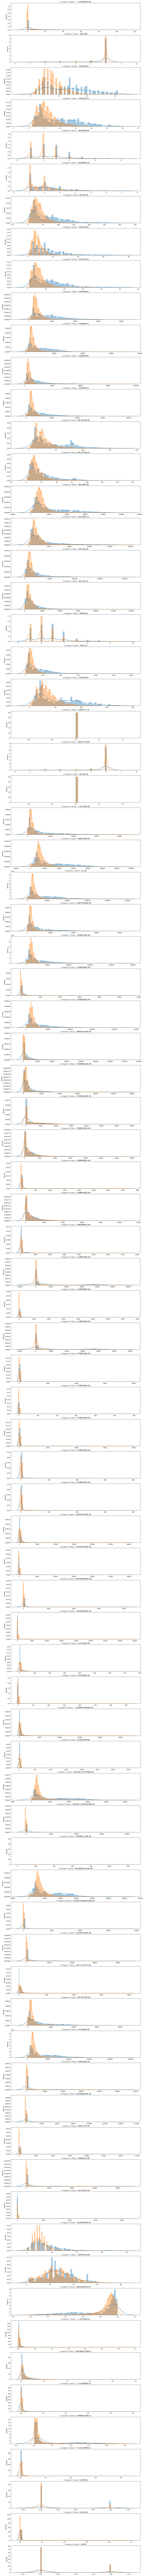

In [25]:
import matplotlib.gridspec as gridspec

v_feat = origin_data.iloc[:,1:81].columns
plt.figure(figsize=(16,80*4))
gs = gridspec.GridSpec(80, 1)
for i, cn in enumerate(origin_data[v_feat]):
    ax = plt.subplot(gs[i])
    sns.distplot(origin_data[cn][origin_data['RES'] == 1], bins=50)
    sns.distplot(origin_data[cn][origin_data['RES'] == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn), fontproperties=zhfont)

if not os.path.isdir('./imgs'):
    os.mkdir('./imgs')

plt.savefig('./imgs/hist_of_OriginData.jpg')

## 数据预处理

In [93]:
# 检查缺失数据
missing_info = pd.DataFrame({'Missing Count': origin_data.isna().sum(), 'Missing Percentage': origin_data.isna().mean() * 100})
missing_info = missing_info.sort_values(by='Missing Percentage')

print("Column-wise missing values summary:")
print(missing_info)

Column-wise missing values summary:
                   Missing Count  Missing Percentage
个人编码                           0                   0
医疗救助个人按比例负担金额_SUM              0                   0
起付标准以上自负比例金额_SUM               0                   0
起付线标准金额_MAX                    0                   0
一次性医用材料申报金额_SUM                0                   0
其它申报金额_SUM                     0                   0
其它发生金额_SUM                     0                   0
成分输血申报金额_SUM                   0                   0
最高限额以上金额_SUM                   0                   0
医用材料费自费金额_SUM                  0                   0
医用材料发生金额_SUM                   0                   0
床位费申报金额_SUM                    0                   0
床位费发生金额_SUM                    0                   0
手术费申报金额_SUM                    0                   0
手术费自费金额_SUM                    0                   0
手术费发生金额_SUM                    0                   0
治疗费申报金额_SUM                    0                   0
高价材料发生金额_S

In [94]:
# 填充
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
data_imputed = origin_data
data_imputed = imputer.fit_transform(data_imputed)
data_imputed = pd.DataFrame(data_imputed, columns=origin_data.columns)

In [95]:
# 检查是否还有缺失
missing_info = pd.DataFrame({'Missing Count': data_imputed.isna().sum(), 'Missing Percentage': data_imputed.isna().mean() * 100})
missing_info = missing_info.sort_values(by='Missing Percentage')

print("Column-wise missing values summary:")
print(missing_info)

Column-wise missing values summary:
                   Missing Count  Missing Percentage
个人编码                           0                   0
最高限额以上金额_SUM                   0                   0
医疗救助个人按比例负担金额_SUM              0                   0
起付标准以上自负比例金额_SUM               0                   0
起付线标准金额_MAX                    0                   0
一次性医用材料申报金额_SUM                0                   0
其它申报金额_SUM                     0                   0
其它发生金额_SUM                     0                   0
基本统筹基金支付金额_SUM                 0                   0
成分输血申报金额_SUM                   0                   0
高价材料发生金额_SUM                   0                   0
医用材料发生金额_SUM                   0                   0
床位费申报金额_SUM                    0                   0
床位费发生金额_SUM                    0                   0
手术费申报金额_SUM                    0                   0
手术费自费金额_SUM                    0                   0
手术费发生金额_SUM                    0                   0
医用材料费自费金额_

In [96]:
origin_data = data_imputed

In [97]:
# 检查是否还有缺失
missing_info = pd.DataFrame({'Missing Count': data_imputed.isna().sum(), 'Missing Percentage': data_imputed.isna().mean() * 100})
missing_info = missing_info.sort_values(by='Missing Percentage')

print("Column-wise missing values summary:")
print(missing_info)

Column-wise missing values summary:
                   Missing Count  Missing Percentage
个人编码                           0                   0
最高限额以上金额_SUM                   0                   0
医疗救助个人按比例负担金额_SUM              0                   0
起付标准以上自负比例金额_SUM               0                   0
起付线标准金额_MAX                    0                   0
一次性医用材料申报金额_SUM                0                   0
其它申报金额_SUM                     0                   0
其它发生金额_SUM                     0                   0
基本统筹基金支付金额_SUM                 0                   0
成分输血申报金额_SUM                   0                   0
高价材料发生金额_SUM                   0                   0
医用材料发生金额_SUM                   0                   0
床位费申报金额_SUM                    0                   0
床位费发生金额_SUM                    0                   0
手术费申报金额_SUM                    0                   0
手术费自费金额_SUM                    0                   0
手术费发生金额_SUM                    0                   0
医用材料费自费金额_

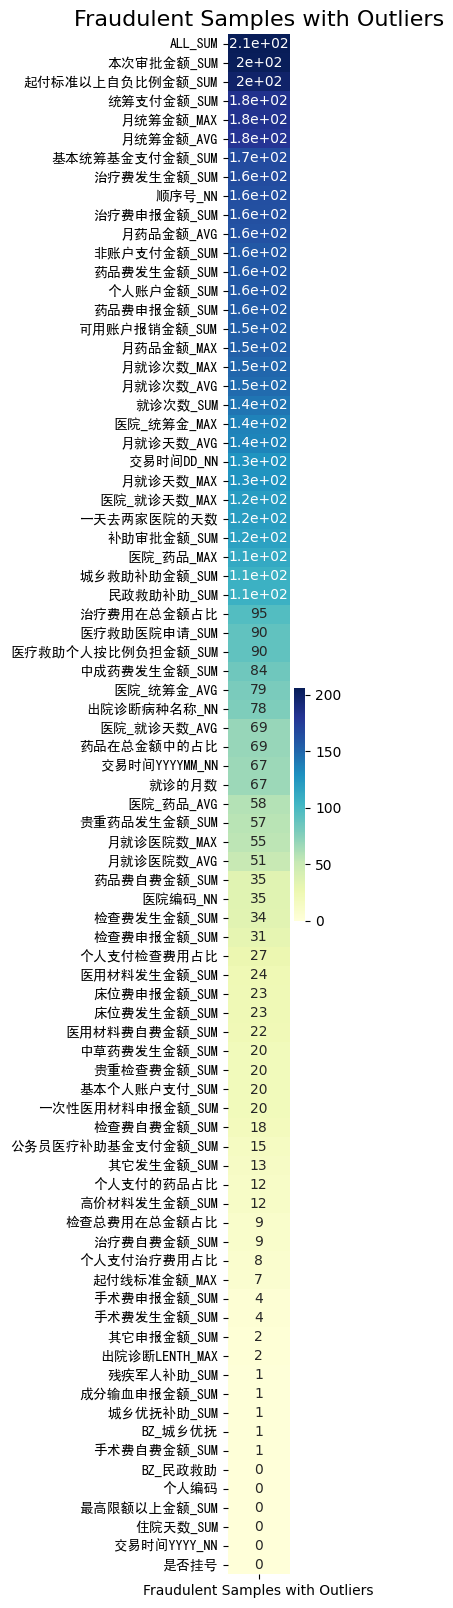

In [98]:
fraud_count_per_feature = {}

# 异常值处理
for column in origin_data.columns[:-1]:
  origin_data[column]
  std_dev = origin_data[column].std()
  mean_val = origin_data[column].mean()
  threshold = 3 * std_dev
  # origin_data[column][abs(origin_data[column] - mean_val) > threshold] = mean_val
  fraud_count = len(origin_data[(abs(origin_data[column] - mean_val) > threshold) & (origin_data['RES'] == 1)])
  # 将结果存储到字典中
  fraud_count_per_feature[column] = fraud_count
# # 打印每个特征中异常值且预测为欺诈样本的数量
# for feature, count in fraud_count_per_feature.items():
#   print(f"Feature '{feature}': {count} fraudulent samples with outliers")

pd.options.display.float_format = '{:.0f}'.format # 禁止科学计数法

df = pd.DataFrame.from_dict(fraud_count_per_feature, orient='index', columns=['Fraudulent Samples with Outliers'])
plt.figure(figsize=(1, 20))
ax = sns.heatmap(df[['Fraudulent Samples with Outliers']].sort_values(by='Fraudulent Samples with Outliers', ascending=False), annot=True, cmap='YlGnBu')
feature_ylabels = ax.get_yticklabels()
ax.set_yticklabels(feature_ylabels, fontproperties=zhfont)
plt.title('Fraudulent Samples with Outliers', fontsize=16)

# save img
if not os.path.isdir('./imgs'):
    os.mkdir('./imgs')

plt.savefig('./imgs/fraudulent_outliers.jpg')

plt.show()

## 训练集-验证集-测试集划分

In [99]:
#划分数据集
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(origin_data, test_size=0.1, random_state=42)

## 数据增强

### 欠采样

In [100]:
from sklearn.cluster import KMeans
import numpy as np

neg_samples = train_data[train_data['RES'] == 0]
neg_samples = train_data[[x for x in origin_data if x != 'RES']]
K = 11
M = 10516 # 需要的正样本数量

# Step 1: 利用Kmeans聚类算法对正常样本进行聚类
kmeans = KMeans(n_clusters=K)
clusters = kmeans.fit_predict(neg_samples)

inertia = kmeans.inertia_
print(inertia)
# Step 2: 计算每个簇样本占总体的比例，确定抽样比例
cluster_counts = np.bincount(clusters)
sampling_ratios = cluster_counts / len(neg_samples)

# Step 3: 从每个簇中按照抽样比例随机抽取正常样本，形成新的正常样本集合
new_neg_samples = pd.DataFrame()
for cluster_id, sampling_ratio in enumerate(sampling_ratios):
    cluster_samples = neg_samples[clusters == cluster_id]
    num_samples_to_select = int(M * sampling_ratio)
    selected_samples = cluster_samples.sample(n=num_samples_to_select, replace=False)
    new_neg_samples = pd.concat([new_neg_samples, selected_samples], axis=0)
    # new_normal_samples = new_normal_samples.append(selected_samples)
new_neg_samples['RES'] = 0
print(new_neg_samples.shape)


3343421421816.3403
(10512, 82)


In [101]:
pos_samples = train_data[train_data['RES'] == 1]
# 合并两个 DataFrame
merged_data = pd.concat([pos_samples, new_neg_samples])

# 随机打乱 DataFrame
shuffled_data = merged_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [102]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11227 entries, 9509 to 630
Data columns (total 82 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   个人编码               11227 non-null  float64
 1   一天去两家医院的天数         11227 non-null  float64
 2   就诊的月数              11227 non-null  float64
 3   月就诊天数_MAX          11227 non-null  float64
 4   月就诊天数_AVG          11227 non-null  float64
 5   月就诊医院数_MAX         11227 non-null  float64
 6   月就诊医院数_AVG         11227 non-null  float64
 7   就诊次数_SUM           11227 non-null  float64
 8   月就诊次数_MAX          11227 non-null  float64
 9   月就诊次数_AVG          11227 non-null  float64
 10  月统筹金额_MAX          11227 non-null  float64
 11  月统筹金额_AVG          11227 non-null  float64
 12  月药品金额_MAX          11227 non-null  float64
 13  月药品金额_AVG          11227 non-null  float64
 14  医院_就诊天数_MAX        11227 non-null  float64
 15  医院_就诊天数_AVG        11227 non-null  float64
 16  医院_统筹金_MAX         11227 n

### 过采样

In [103]:
# 查看正负样本比例
data = train_data
X = data[features]
y = data[target]

n_sample = y.shape[0]
n_pos_sample = y[y == 1].shape[0]
n_neg_sample = y[y == 0].shape[0]
print('正样本个数：{}； 负样本个数{}'.format(n_pos_sample, n_neg_sample))
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
print('特征维数：', X.shape[1])

正样本个数：715； 负样本个数13685
样本个数：14400; 正样本占4.97%; 负样本占95.03%
特征维数： 81


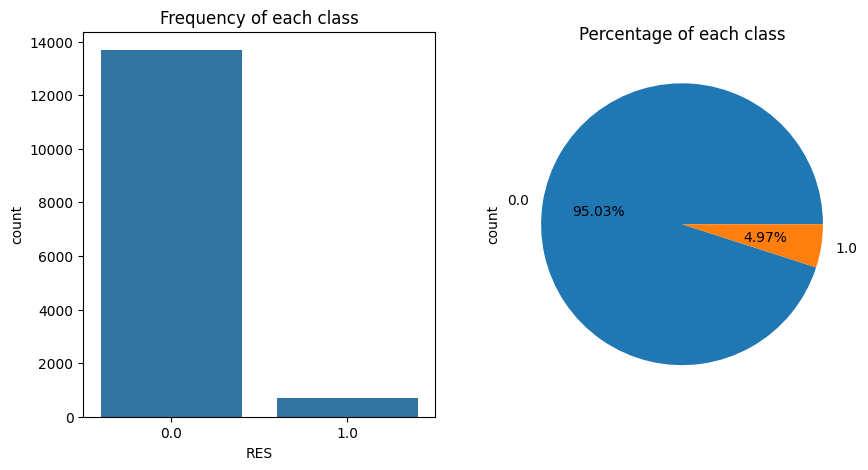

In [104]:
# 画图
fig, axs = plt.subplots(1, 2, figsize=(10,5))
sns.countplot(x='RES', data=data, ax=axs[0])
axs[0].set_title('Frequency of each class')
data['RES'].value_counts().plot(x=None, y=None, kind='pie', ax=axs[1], autopct='%1.2f%%')
axs[1].set_title('Percentage of each class')
plt.show()

In [105]:
from imblearn.over_sampling import SMOTE # 导入SMOTE算法模块
# 处理不平衡数据
sm = SMOTE(sampling_strategy={1:958}, random_state=42)    # 处理过采样的方法
X, y = sm.fit_resample(X, y)

print('通过SMOTE方法平衡正负样本后')
n_sample = y.shape[0]
n_pos_sample = y[y == 1].shape[0]
n_neg_sample = y[y == 0].shape[0]

print('正样本个数：{}； 负样本个数{}'.format(n_pos_sample, n_neg_sample))
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
print('特征维数：', X.shape[1])

通过SMOTE方法平衡正负样本后
正样本个数：958； 负样本个数13685
样本个数：14643; 正样本占6.54%; 负样本占93.46%
特征维数： 81


In [106]:
# 查看重采样后的数据
data_resampled = pd.concat([X, y], axis=1)
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14643 entries, 0 to 14642
Data columns (total 82 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   个人编码               14643 non-null  float64
 1   一天去两家医院的天数         14643 non-null  float64
 2   就诊的月数              14643 non-null  float64
 3   月就诊天数_MAX          14643 non-null  float64
 4   月就诊天数_AVG          14643 non-null  float64
 5   月就诊医院数_MAX         14643 non-null  float64
 6   月就诊医院数_AVG         14643 non-null  float64
 7   就诊次数_SUM           14643 non-null  float64
 8   月就诊次数_MAX          14643 non-null  float64
 9   月就诊次数_AVG          14643 non-null  float64
 10  月统筹金额_MAX          14643 non-null  float64
 11  月统筹金额_AVG          14643 non-null  float64
 12  月药品金额_MAX          14643 non-null  float64
 13  月药品金额_AVG          14643 non-null  float64
 14  医院_就诊天数_MAX        14643 non-null  float64
 15  医院_就诊天数_AVG        14643 non-null  float64
 16  医院_统筹金_MAX         146

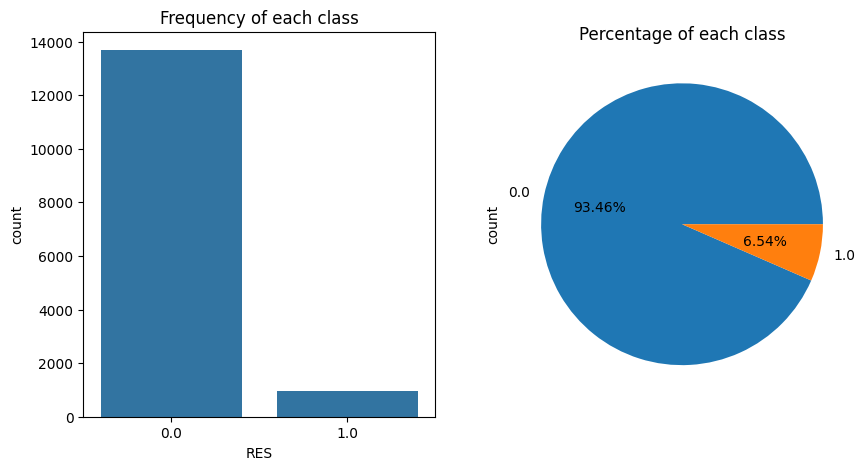

In [107]:
# 画图
fig, axs = plt.subplots(1, 2, figsize=(10,5))
sns.countplot(x='RES', data=data_resampled, ax=axs[0])
axs[0].set_title('Frequency of each class')
data_resampled['RES'].value_counts().plot(x=None, y=None, kind='pie', ax=axs[1], autopct='%1.2f%%')
axs[1].set_title('Percentage of each class')
plt.show()

## 特征筛选

### 直方图

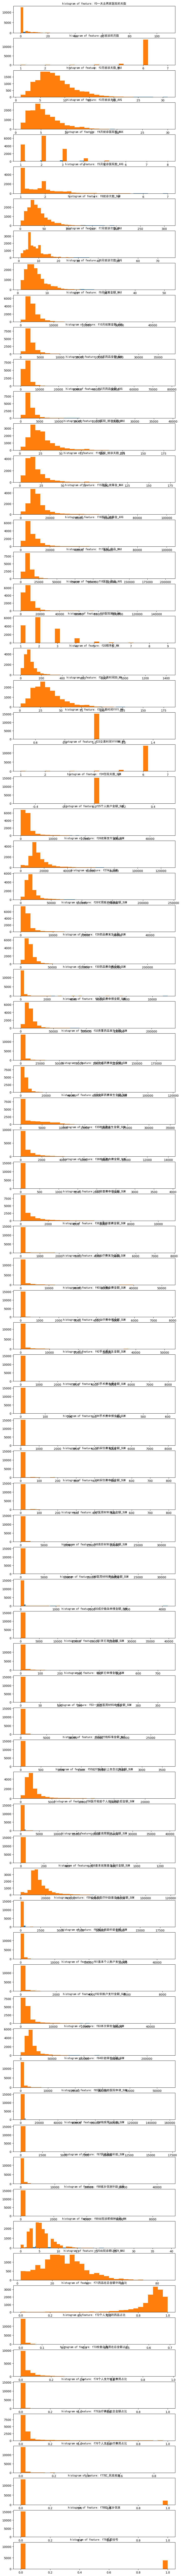

In [27]:
import matplotlib.gridspec as gridspec
data = origin_data
v_feat = data.iloc[:,1:81].columns
plt.figure(figsize=(10,81*4))
gs = gridspec.GridSpec(81 * 2, 1)
for i, cn in enumerate(data[v_feat]):
    ax = plt.subplot(gs[i])
    ax.hist(data[cn][data['RES'] == 1], bins=30)
    ax.hist(data[cn][data['RES'] == 0], bins=30)
    ax.set_xlabel('')
    ax.set_title(f'histogram of feature: f{i}' + str(cn), fontproperties=zhfont)

### 相关系数筛选

In [10]:
data = origin_data

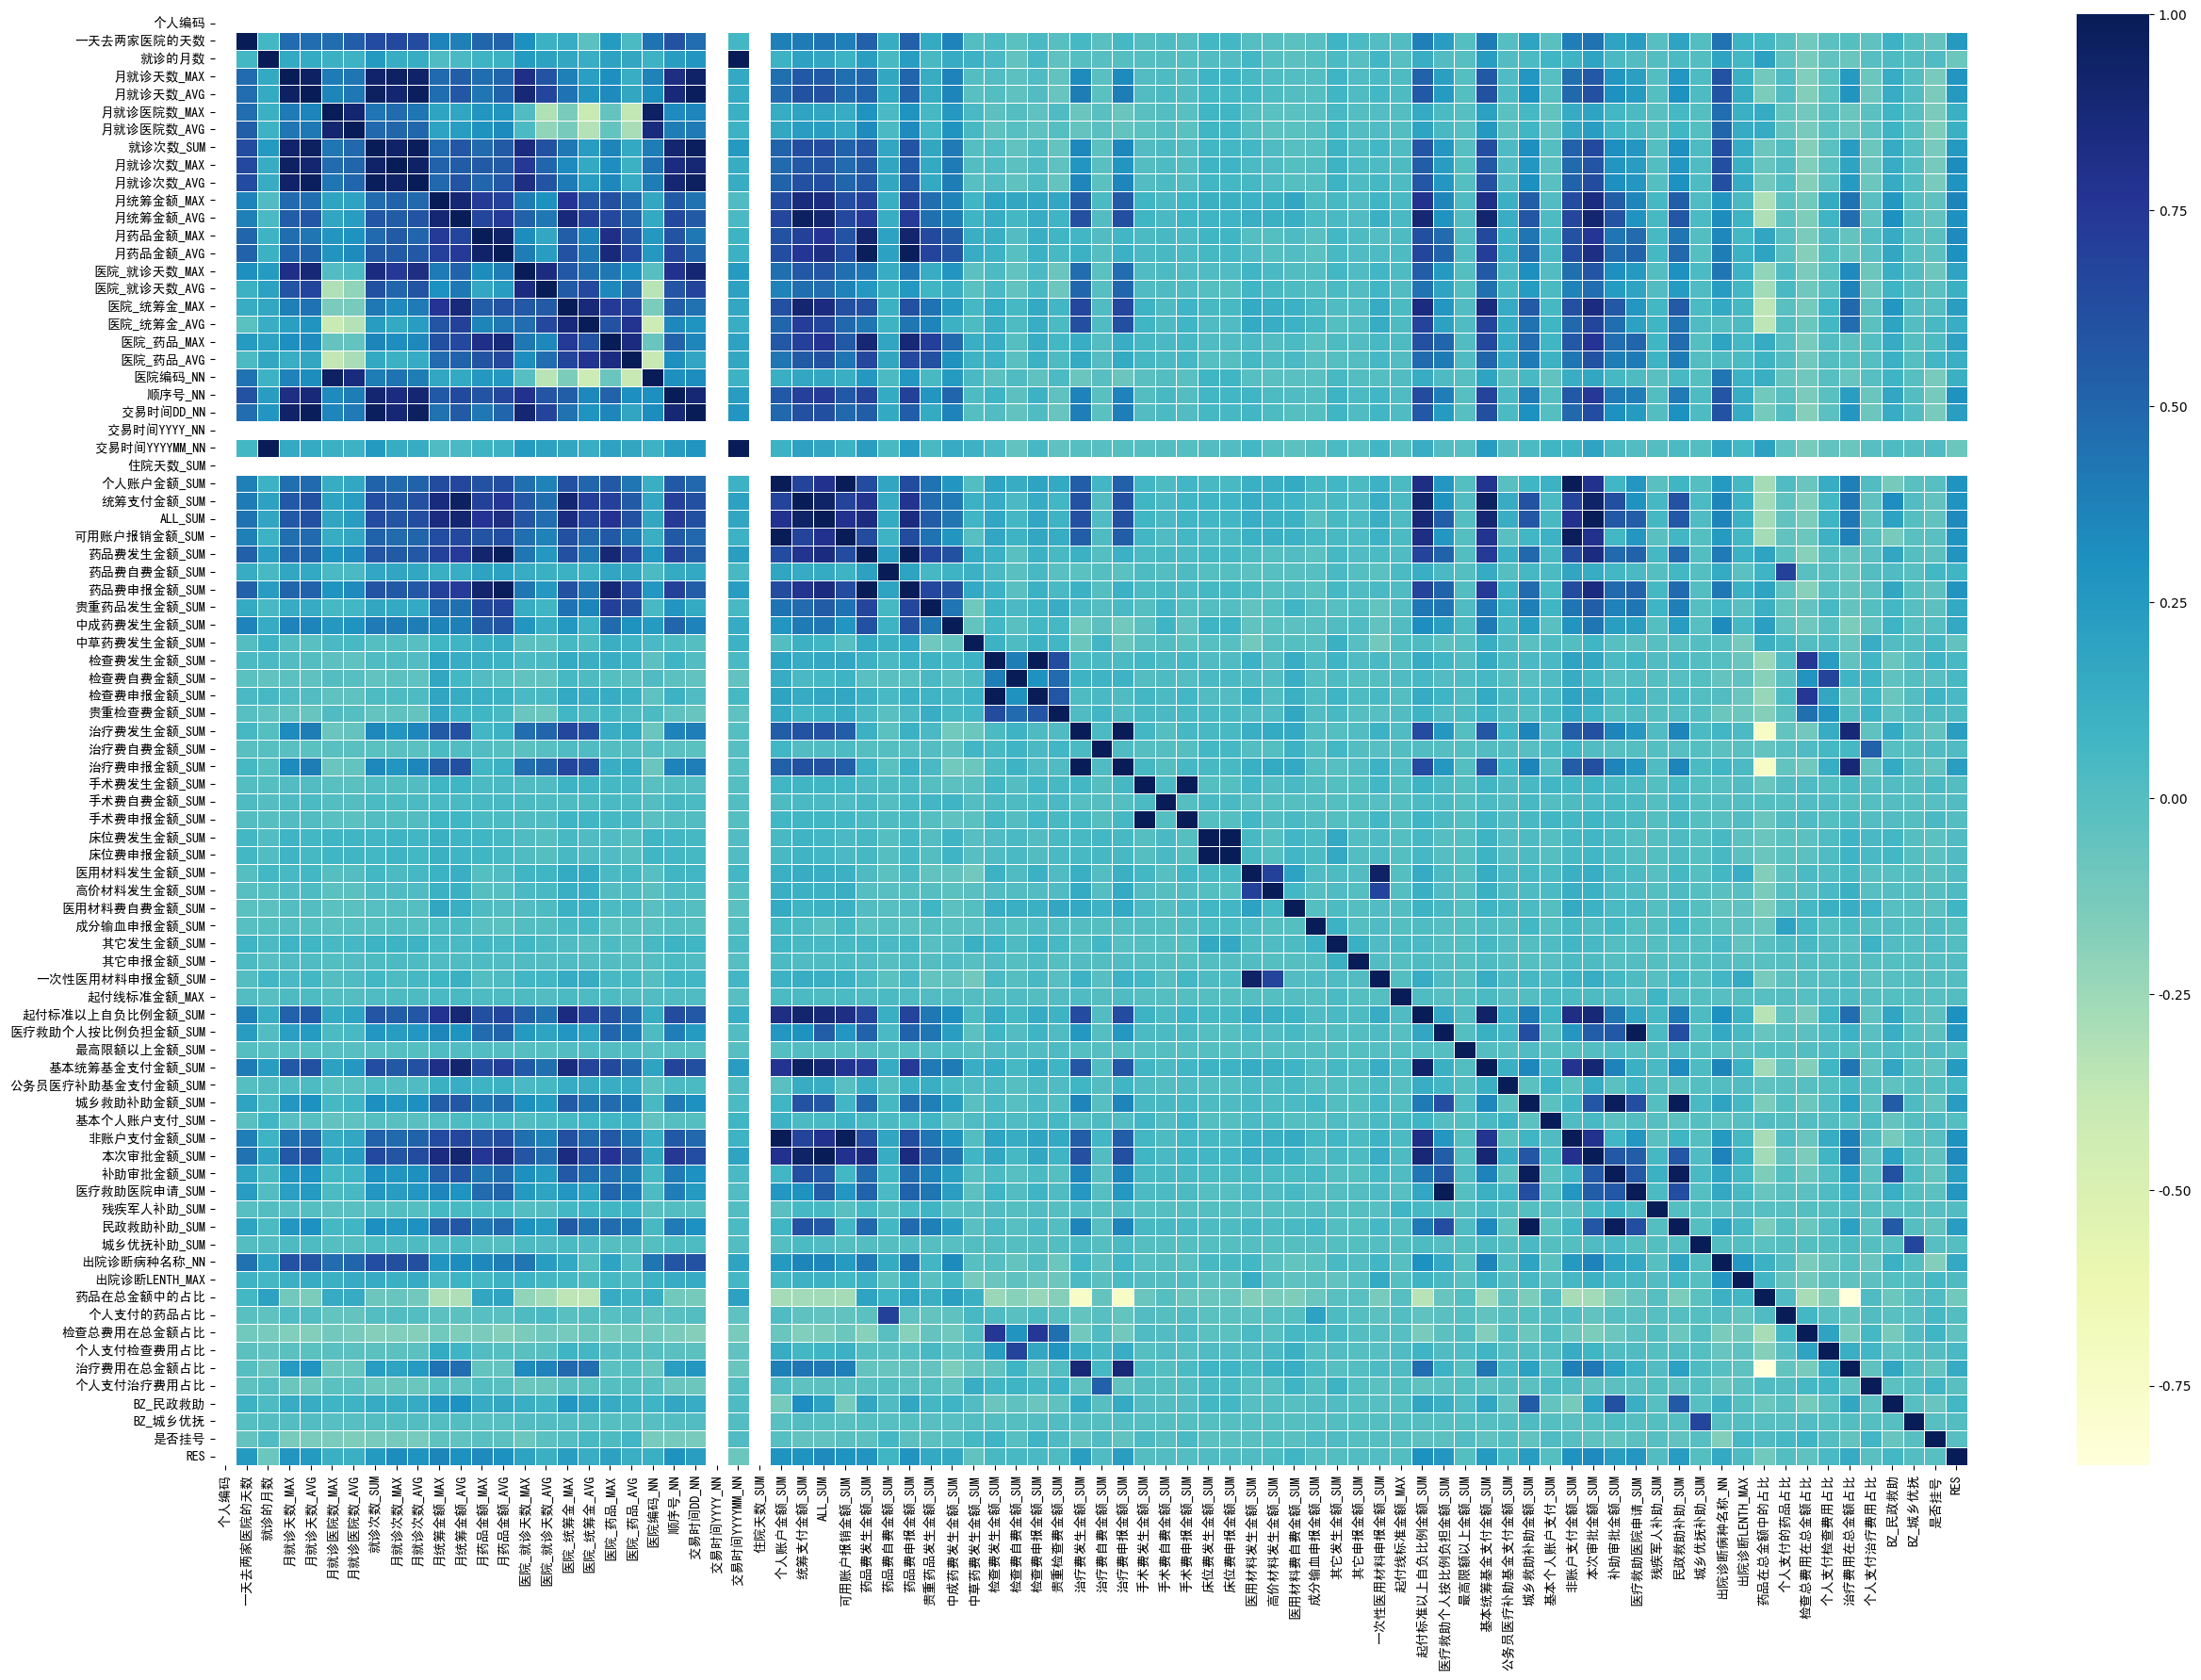

In [11]:
fig = plt.figure(figsize=(30, 20))
ax = sns.heatmap(data.corr(), annot=False, cmap='YlGnBu', linewidths=0.5)
feature_xlabels = ax.get_xticklabels()
feature_ylabels = ax.get_yticklabels()
ax.set_xticklabels(feature_xlabels, fontproperties=zhfont)
ax.set_yticklabels(feature_ylabels, fontproperties=zhfont)
plt.show()

In [12]:
data.corr()['RES'].sort_values(ascending=False).drop(['RES'], axis=0)

月统筹金额_MAX             0
ALL_SUM               0
本次审批金额_SUM            0
月药品金额_MAX             0
月就诊次数_MAX             0
月药品金额_AVG             0
月统筹金额_AVG             0
起付标准以上自负比例金额_SUM      0
顺序号_NN                0
非账户支付金额_SUM           0
个人账户金额_SUM            0
月就诊次数_AVG             0
可用账户报销金额_SUM          0
统筹支付金额_SUM            0
药品费发生金额_SUM           0
药品费申报金额_SUM           0
月就诊天数_MAX             0
医疗救助医院申请_SUM          0
医疗救助个人按比例负担金额_SUM     0
月就诊天数_AVG             0
就诊次数_SUM              0
一天去两家医院的天数            0
基本统筹基金支付金额_SUM        0
民政救助补助_SUM            0
城乡救助补助金额_SUM          0
补助审批金额_SUM            0
治疗费发生金额_SUM           0
治疗费申报金额_SUM           0
交易时间DD_NN             0
医院_统筹金_MAX            0
医院_药品_MAX             0
医院_就诊天数_MAX           0
出院诊断病种名称_NN           0
贵重药品发生金额_SUM          0
中成药费发生金额_SUM          0
治疗费用在总金额占比            0
医院_统筹金_AVG            0
医院_药品_AVG             0
月就诊医院数_MAX            0
医院编码_NN               0
医院_就诊天数_AVG           0
月就诊医院数_AVG      

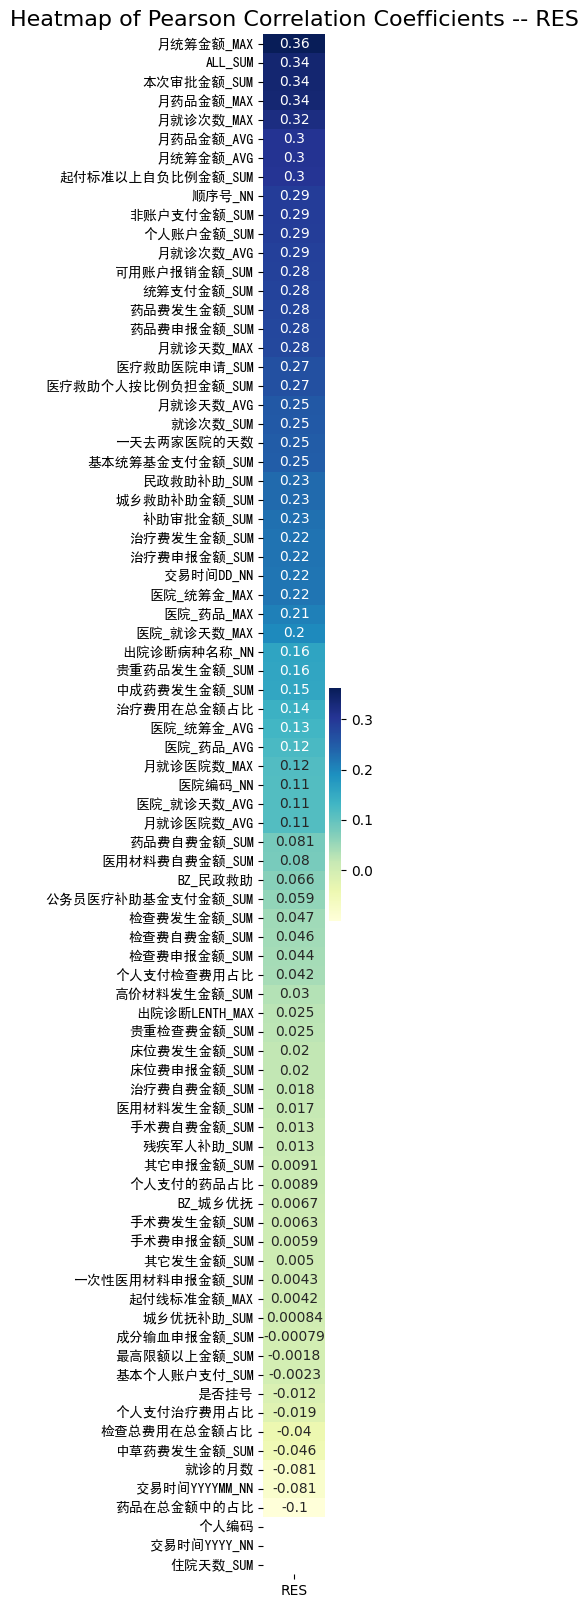

In [13]:
plt.figure(figsize=(1, 20))
ax = sns.heatmap(data.corr()[['RES']].sort_values(by='RES', ascending=False).drop(['RES'], axis=0), annot=True, cmap='YlGnBu', linewidths=0.0025)
feature_ylabels = ax.get_yticklabels()
ax.set_yticklabels(feature_ylabels, fontproperties=zhfont)
plt.title('Heatmap of Pearson Correlation Coefficients -- RES', fontsize=16)

# save img
if not os.path.isdir('./imgs'):
    os.mkdir('./imgs')

plt.savefig('./imgs/corrHeatmap_RES.jpg')

plt.show()

In [14]:
correlation_with_res = data.corr()['RES'].drop(['RES'])

# 筛选出相关系数大于0.1的特征
selected_features_pearson = correlation_with_res[correlation_with_res > 0.1].index.tolist()

print(selected_features_pearson)
print(len(selected_features_pearson))


['一天去两家医院的天数', '月就诊天数_MAX', '月就诊天数_AVG', '月就诊医院数_MAX', '月就诊医院数_AVG', '就诊次数_SUM', '月就诊次数_MAX', '月就诊次数_AVG', '月统筹金额_MAX', '月统筹金额_AVG', '月药品金额_MAX', '月药品金额_AVG', '医院_就诊天数_MAX', '医院_就诊天数_AVG', '医院_统筹金_MAX', '医院_统筹金_AVG', '医院_药品_MAX', '医院_药品_AVG', '医院编码_NN', '顺序号_NN', '交易时间DD_NN', '个人账户金额_SUM', '统筹支付金额_SUM', 'ALL_SUM', '可用账户报销金额_SUM', '药品费发生金额_SUM', '药品费申报金额_SUM', '贵重药品发生金额_SUM', '中成药费发生金额_SUM', '治疗费发生金额_SUM', '治疗费申报金额_SUM', '起付标准以上自负比例金额_SUM', '医疗救助个人按比例负担金额_SUM', '基本统筹基金支付金额_SUM', '城乡救助补助金额_SUM', '非账户支付金额_SUM', '本次审批金额_SUM', '补助审批金额_SUM', '医疗救助医院申请_SUM', '民政救助补助_SUM', '出院诊断病种名称_NN', '治疗费用在总金额占比']
42


### PCA主成分分析

In [ ]:
# 使用sklearn的PCA进行降维
def apply_pca(data, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    transformed_data = pca.transform(data)
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)
    return transformed_data, explained_variance_ratio

# PCA降维至2维并可视化
lowDDataMat, explained_variance_ratio_2d = apply_pca(x_data_scaled, 2)
x_2d = lowDDataMat[:, 0]
y_2d = lowDDataMat[:, 1]
plt.scatter(x_2d, y_2d, c='r')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA')
plt.show()
print("降维二维后的表示程度: {:.2f}%".format(explained_variance_ratio_2d * 100))

# PCA降维至3维并可视化
lowDDataMat, explained_variance_ratio_3d = apply_pca(x_data_scaled, 3)
x_3d = lowDDataMat[:, 0]
y_3d = lowDDataMat[:, 1]
z_3d = lowDDataMat[:, 2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_3d, y_3d, z_3d, c=y_data, s=10)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA')
plt.show()
print("降维三维后的表示程度: {:.2f}%".format(explained_variance_ratio_3d * 100))

digits['x'] = x_3d
digits['y'] = y_3d
digits['z'] = z_3d

digits.to_excel('data_imputedByAverage_pca3.xlsx',index=None)

## 模型训练

### xgb

In [108]:
#划分数据集
from sklearn.model_selection import train_test_split

data_target = train_data['RES']
data_features = train_data[[x for x in train_data.columns if x != 'RES']]

x_train, x_valid, y_train, y_valid = train_test_split(data_features, data_target, test_size=0.2, random_state=42)
y_test = test_data['RES']
x_test = test_data[[x for x in test_data.columns if x != 'RES']]

In [109]:
# 导入模型
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
params = {
    'learning_rate': 0.3,
    'n_estimators': 100,
    'max_depth': 4,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'gamma': 0,
    'min_child_weight': 3,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree' :0.8,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'seed': 42
}

clf_xgb = XGBClassifier(**params)
clf_xgb.fit(x_train, y_train)

# 模型预测
train_predict = clf_xgb.predict(x_train)
valid_predict = clf_xgb.predict(x_valid)
test_predict = clf_xgb.predict(x_test)

#------------------------------------------------------------------------------------------------

# 查看train混淆矩阵
from sklearn import metrics

confusion_matrix_result = metrics.confusion_matrix(train_predict, y_train)
print('The confusion matrix result:\n', confusion_matrix_result)

print('classification_report')
print(metrics.classification_report(train_predict, y_train))

# 查看valid混淆矩阵
from sklearn import metrics

confusion_matrix_result = metrics.confusion_matrix(valid_predict, y_valid)
print('The confusion matrix result:\n', confusion_matrix_result)

print('classification_report')
print(metrics.classification_report(valid_predict, y_valid))

# 查看test混淆矩阵
from sklearn import metrics

confusion_matrix_result = metrics.confusion_matrix(test_predict, y_test)
print('The confusion matrix result:\n', confusion_matrix_result)

print('classification_report')
print(metrics.classification_report(test_predict, y_test))

#------------------------------------------------------------------------------------------------

# 绘制ROC曲线
# from sklearn.metrics import auc
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(test_predict, y_test)
# roc_auc = auc(fpr,tpr)


# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b',label='AUC = %0.5f'% roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.0])
# plt.ylim([-0.1,1.01])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

#------------------------------------------------------------------------------------------------

# # 绘制各个feat的importance并排序
# import seaborn as sns
# from xgboost import plot_importance

# fig, ax = plt.subplots(figsize=(8, 20))
# importance = clf_xgb.feature_importances_
# feature_names = clf_xgb.feature_names_in_
# df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
# df_importance.sort_values(by='Importance', ascending=False, inplace=True)
# sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis', ax=ax)
# feature_labels = ax.get_yticklabels()
# ax.set_yticklabels(feature_labels, fontproperties=zhfont)
# ax.set_title('Feature Importance')
# for i, v in enumerate(df_importance['Importance']):
#     ax.text(v + 0.01, i, f'{v:.2f}', va='center')
# plt.show()

The confusion matrix result:
 [[10961   106]
 [    1   452]]
classification_report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     11067
           1       0.81      1.00      0.89       453

    accuracy                           0.99     11520
   macro avg       0.90      0.99      0.94     11520
weighted avg       0.99      0.99      0.99     11520

The confusion matrix result:
 [[2701   96]
 [  22   61]]
classification_report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2797
           1       0.39      0.73      0.51        83

    accuracy                           0.96      2880
   macro avg       0.69      0.85      0.74      2880
weighted avg       0.97      0.96      0.97      2880

The confusion matrix result:
 [[1513   47]
 [   9   31]]
classification_report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1

### 随机森林

In [18]:
# 导入模型
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance

clf_xgb = RandomForestClassifier()
clf_xgb.fit(x_train,y_train)

# 模型预测
train_predict = clf_xgb.predict(x_train)
valid_predict = clf_xgb.predict(x_valid)
test_predict = clf_xgb.predict(x_test)

#------------------------------------------------------------------------------------------------

# 查看train混淆矩阵
from sklearn import metrics

confusion_matrix_result = metrics.confusion_matrix(train_predict, y_train)
print('The confusion matrix result:\n', confusion_matrix_result)

print('classification_report')
print(metrics.classification_report(train_predict, y_train))

# 查看valid混淆矩阵
from sklearn import metrics

confusion_matrix_result = metrics.confusion_matrix(valid_predict, y_valid)
print('The confusion matrix result:\n', confusion_matrix_result)

print('classification_report')
print(metrics.classification_report(valid_predict, y_valid))

# 查看test混淆矩阵
from sklearn import metrics

confusion_matrix_result = metrics.confusion_matrix(test_predict, y_test)
print('The confusion matrix result:\n', confusion_matrix_result)

print('classification_report')
print(metrics.classification_report(test_predict, y_test))

#------------------------------------------------------------------------------------------------

# 绘制ROC曲线
# from sklearn.metrics import auc
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(test_predict, y_test)
# roc_auc = auc(fpr,tpr)


# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b',label='AUC = %0.5f'% roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.0])
# plt.ylim([-0.1,1.01])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

#------------------------------------------------------------------------------------------------

# # 绘制各个feat的importance并排序
# import seaborn as sns
# from xgboost import plot_importance

# fig, ax = plt.subplots(figsize=(8, 20))
# importance = clf_xgb.feature_importances_
# feature_names = clf_xgb.feature_names_in_
# df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
# df_importance.sort_values(by='Importance', ascending=False, inplace=True)
# sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis', ax=ax)
# feature_labels = ax.get_yticklabels()
# ax.set_yticklabels(feature_labels, fontproperties=zhfont)
# ax.set_title('Feature Importance')
# for i, v in enumerate(df_importance['Importance']):
#     ax.text(v + 0.01, i, f'{v:.2f}', va='center')
# plt.show()

The confusion matrix result:
 [[10962     0]
 [    0   558]]
classification_report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10962
         1.0       1.00      1.00      1.00       558

    accuracy                           1.00     11520
   macro avg       1.00      1.00      1.00     11520
weighted avg       1.00      1.00      1.00     11520

The confusion matrix result:
 [[2707  106]
 [  16   51]]
classification_report
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      2813
         1.0       0.32      0.76      0.46        67

    accuracy                           0.96      2880
   macro avg       0.66      0.86      0.72      2880
weighted avg       0.98      0.96      0.97      2880

The confusion matrix result:
 [[1519   53]
 [   3   25]]
classification_report
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1

In [19]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

train_data = pd.read_excel('./train_data.xlsx')
val_data = pd.read_excel('./val_data.xlsx')
test_data = pd.read_excel('./test_data.xlsx')

X_train = train_data[[x for x in train_data.columns if x != 'RES']]
y_train = train_data['RES']


X_test = test_data[[x for x in train_data.columns if x != 'RES']]
y_test = test_data['RES']

# 定义超参数范围
param_grid = {
      'n_estimators':[50,120,160,200,250],
      'max_depth':[1,2,3,5,7,9],
      'min_samples_split':[80,100,120,140],
      'max_features':[3,5,7,9,11]
}

# 创建XGBoost分类器
clf_rf = RandomForestClassifier(tree_method='gpu_hist')
# clf_rf = RandomForestClassifier()

# 使用GridSearchCV进行交叉验证
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, scoring='f1', cv=3)
grid_search.fit(X_train, y_train)

# 输出最佳超参数组合
print("Best parameters found: ", grid_search.best_params_)

# 使用测试集评估模型
best_model = grid_search.best_estimator_
test_pred = best_model.predict(X_test)

# 打印混淆矩阵
confusion_matrix_result = metrics.confusion_matrix(test_pred, y_test)
print('The confusion matrix result:\n', confusion_matrix_result)

# 打印p值、r值、f1值
print('classification_report')
print(metrics.classification_report(test_pred, y_test))

FileNotFoundError: [Errno 2] No such file or directory: './train_data.xlsx'

### SVM

In [ ]:
from sklearn.svm import SVC
clf_svm = SVC(kernel='sigmoid')
clf_svm.fit(x_train, y_train)

train_predict = clf_svm.predict(x_train)
test_predict = clf_svm.predict(x_test)

from sklearn import metrics

# 查看混淆矩阵
confusion_matrix_result = metrics.confusion_matrix(test_predict, y_test)
print('The confusion matrix result:\n', confusion_matrix_result)

print('classification_report')
print(metrics.classification_report(y_test,test_predict))

The confusion matrix result:
 [[2979 1573]
 [1505 3068]]
classification_report
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      4484
           1       0.67      0.66      0.67      4641

    accuracy                           0.66      9125
   macro avg       0.66      0.66      0.66      9125
weighted avg       0.66      0.66      0.66      9125

